## Movie Recommendation Systems

### CSC577

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, ndcg_score
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Install required packages
!pip install nltk
!pip install lightfm --upgrade
!pip install gradio

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# LightFM imports
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

# For UI
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831125 sha256=3638daee1e26543aae00b6a497d6319e2a087141f21f19485e9a6f349a7ce03c
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **1. Load & Prepare Data**

In [ ]:
# Load the dataset
movieData = pd.read_csv("cleanedmovies.csv")
copy_movieData = movieData.copy()

# Display the first few rows to understand the data structure
movieData

,userId,movieId,rating,timestamp,index,adult,budget,genres,original_language,original_title,...,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors,production_company_names
0,150,6,3.0,945064289,472.0,True,0.0,"Action, Thriller, Crime",en,Judgment Night,...,110.0,['English'],Don't move. Don't whisper. Don't even breathe.,6.4,79.0,"['chicago', 'drug dealer', 'boxing match', 'es...","[{'credit_id': '52fe420dc3a36847f800023d', 'de...","Frank Wyatt, Mike Peterson, Fallon, Ray Cochra...","Emilio Estevez, Cuba Gooding Jr., Denis Leary,...","['Universal Pictures', 'Largo Entertainment', ..."
1,150,16,5.0,945064264,3726.0,True,12800000.0,"Drama, Crime, Music",en,Dancer in the Dark,...,140.0,['English'],You don't need eyes to see.,7.7,392.0,"['individual', 'dancing', 'usa', 'robbery', 'f...","[{'credit_id': '52fe420ec3a36847f8000981', 'de...","Selma Jezkova, Kathy, Bill Houston, Jeff, Oldr...","Björk, Catherine Deneuve, David Morse, Peter S...","['Fine Line Features', 'Zentropa Entertainment..."
2,150,21,3.0,945065011,3476.0,True,0.0,Documentary,en,The Endless Summer,...,95.0,['English'],Unknown,7.8,23.0,"['surfer', 'surfboard', 'surfing']","[{'credit_id': '52fe420fc3a36847f8000dc1', 'de...","Himself, Himself, Himself, Narrator, Himself, ...","Michael Hynson, Robert August, Lord 'Tally Ho'...",['Bruce Brown Films']
3,150,25,3.0,945064264,10230.0,True,72000000.0,"Drama, War",en,Jarhead,...,125.0,"['English', 'Español', 'العربية', 'Latin']",Welcome to the suck.,6.6,776.0,"['sniper', 'marine corps', 'saudi arabia', 'pe...","[{'credit_id': '52fe4210c3a36847f8001145', 'de...","Staff Sgt. Sykes, Anthony Swofford, D.I. Fitch...","Jamie Foxx, Jake Gyllenhaal, Scott MacDonald, ...","['Universal Pictures', 'Neal Street Production..."
4,150,62,3.0,945065341,882.0,True,10500000.0,"Science Fiction, Mystery, Adventure",en,2001: A Space Odyssey,...,149.0,"['English', 'Pусский']",An epic drama of adventure and exploration,7.9,3075.0,"['moon', 'jupiter', 'artificial intelligence',...","[{'credit_id': '52fe4212c3a36847f8001a0b', 'de...","Dr. Dave Bowman, Dr. Frank Poole, Dr. Heywood ...","Keir Dullea, Gary Lockwood, William Sylvester,...","['Stanley Kubrick Productions', 'Metro-Goldwyn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,48329,1090,4.0,1426526703,2514.0,True,16000000.0,"Thriller, Science Fiction, Mystery",en,The Thirteenth Floor,...,100.0,['English'],Question reality. You can go there even though...,6.8,381.0,"['artificial intelligence', 'simulation', 'com...","[{'credit_id': '52fe42e7c3a36847f802b905', 'de...","Douglas Hall/John Ferguson/David, Hannon Fulle...","Craig Bierko, Armin Mueller-Stahl, Gretchen Mo...","['Columbia Pictures', 'Centropolis Film Produc..."
99996,48329,1092,3.0,1426533222,1151.0,True,0.0,"Thriller, Mystery",en,The Third Man,...,104.0,"['English', 'Pусский', 'Deutsch']",Hunted by men ... Sought by WOMEN!,7.9,431.0,"['austria', 'cemetery', 'famous score', 'black...","[{'credit_id': '58d8fdf5c3a368121b065001', 'de...","Holly Martins, Anna Schmidt, Harry Lime, Major...","Joseph Cotten, Alida Valli, Orson Welles, Trev...","['London Film Productions', 'British Lion Film..."
99997,48329,1213,4.5,1426524837,3007.0,True,40000000.0,"Thriller, Crime, Drama",en,The Talented Mr. Ripley,...,139.0,"['English', 'Italiano']",How far would you go to become someone else?,7.1,790.0,"['venice', 'italy', 'gay', 'new york', 'lovesi...","[{'credit_id': '57c75cc39251410a5600036f', 'de...","Tom Ripley, Marge Sherwood, Dickie Greenleaf, ...","Matt Damon, Gwyneth Paltrow, Jude Law, Cate Bl...","['Paramount Pictures', 'Miramax Films', 'Timni..."
99998,48329,1246,3.5,1426935535,11114.0,True,24000000.0,Drama,en,Rocky Balboa,...,102.0,"['English', 'Español']",It ain't over 'til it's over.,6.5,858.0,"['philadelphia', 'transporter', 'fight', ""love...","[{'credit_id': '52fe42e9c3a36847f802c5f9', 'de...","Rocky Balboa, Paulie, Rocky Jr., Marie, Steps,...","Sylvester 

In [ ]:
# Check the columns in the dataset
print("Columns in the dataset:")
print(movieData.columns.tolist())

# Check for missing values
print("\nMissing values in each column:")
print(movieData.isnull().sum())

Columns in the dataset:
['userId', 'movieId', 'rating', 'timestamp', 'index', 'adult', 'budget', 'genres', 'original_language', 'original_title', 'overview', 'popularity', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'tagline', 'vote_average', 'vote_count', 'keywords', 'crew', 'characters', 'actors', 'production_company_names']

Missing values in each column:
userId                      0
movieId                     0
rating                      0
timestamp                   0
index                       0
adult                       0
budget                      0
genres                      0
original_language           0
original_title              0
overview                    0
popularity                  0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
tagline                     0
vote_average                0
vote_count                  0
k

In [ ]:
# Created a copy of user id, movie id, and rating dataframe
df = movieData[['userId', 'movieId', 'rating', 'original_title', 'popularity', 'genres']].copy()

# Implicit rating of copied dataframe of setting values to 1 if rating is above 3.5 else 0
df['implicit_rating'] = df['rating'].apply(lambda x: 1 if x >= 3.5 else 0)

# Create mappings between IDs and indices
userId_to_index = {user_id: index for index, user_id in enumerate(df['userId'].unique())}
movieId_to_index = {movie_id: index for index, movie_id in enumerate(df['movieId'].unique())}

# Create reverse mappings for later use
index_to_userId = {index: user_id for user_id, index in userId_to_index.items()}
index_to_movieId = {index: movie_id for movie_id, index in movieId_to_index.items()}

# Create a movie info dataframe for easy lookup
movie_info = df[['movieId', 'original_title', 'genres']].drop_duplicates().set_index('movieId')

print(f"Loaded {len(df)} ratings from {len(userId_to_index)} users on {len(movieId_to_index)} movies")

Loaded 100000 ratings from 774 users on 212 movies


## **2. Search Engine (Multi-Field Indexing)**

In [ ]:
# Create a search engine using TF-IDF
def create_search_engine(df):
    """
    Create a TF-IDF based search engine for movies
    """
    print("Creating search engine...")

    # Combine searchable fields
    search_df = df[['movieId', 'original_title']].drop_duplicates()

    # Add overview, genres, and keywords if they exist in the dataframe
    additional_fields = ['overview', 'genres', 'keywords']
    for field in additional_fields:
        if field in df.columns:
            search_df = pd.merge(search_df, df[['movieId', field]].drop_duplicates(), on='movieId', how='left')

    # Fill NaN values
    for col in additional_fields:
        if col in search_df.columns:
            search_df[col] = search_df[col].fillna('')

    # Combine fields for searching
    search_text_parts = [search_df['original_title']]
    for field in additional_fields:
        if field in search_df.columns:
            search_text_parts.append(search_df[field])

    search_df['search_text'] = pd.concat(search_text_parts, axis=1).apply(lambda x: ' '.join(x.astype(str)), axis=1)

    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(search_df['search_text'])

    print(f"Created search index with {tfidf_matrix.shape[1]} features")

    return search_df, tfidf, tfidf_matrix

# Function to search for movies
def search_movies(query, search_df, tfidf, tfidf_matrix, top_n=10):
    """
    Search for movies based on a query
    """
    # Transform the query using the same vectorizer
    query_vec = tfidf.transform([query])

    # Calculate similarity between query and all movies
    similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get indices of top N similar movies
    indices = similarity.argsort()[-top_n:][::-1]

    # Return the movie info for these indices
    results = search_df.iloc[indices][['movieId', 'original_title', 'genres']]
    results['similarity'] = similarity[indices]

    return results

In [ ]:
# Create the search engine
search_df, tfidf, tfidf_matrix = create_search_engine(movieData)

# Test the search functionality
search_query = "action adventure"
search_results = search_movies(search_query, search_df, tfidf, tfidf_matrix, top_n=5)
print(f"Search results for '{search_query}':")
search_results

Creating search engine...
Created search index with 4385 features
Search results for 'action adventure':


,movieId,original_title,genres,similarity
30,551,The Poseidon Adventure,"Action, Adventure",0.214100
77,2023,Hidalgo,"Western, Adventure",0.141510
145,2019,Hard Target,"Action, Adventure, Crime, Thriller",0.134568
82,2268,The Golden Compass,"Adventure, Fantasy",0.132346
210,494,Shaft in Africa,"Adventure, Action, Thriller, Crime, Mystery",0.130901


## **3. Non-Personalized Recommendation (Popularity-Based)**

In [ ]:
# Function to create popularity-based recommendations
def create_popularity_recommendations(df, top_n=10):
    """
    Create popularity-based recommendations using vote_average and vote_count
    """
    print("Creating popularity-based recommendations...")

    # Create a copy of the dataframe with relevant columns
    pop_df = df[['movieId', 'original_title', 'genres']].drop_duplicates()

    # Add vote_average and vote_count if they exist
    if 'vote_average' in df.columns and 'vote_count' in df.columns:
        vote_df = df[['movieId', 'vote_average', 'vote_count']].drop_duplicates()
        pop_df = pd.merge(pop_df, vote_df, on='movieId', how='left')
    else:
        # If vote columns don't exist, use rating data to calculate average and count
        rating_stats = df.groupby('movieId').agg({
            'rating': ['mean', 'count']
        }).reset_index()
        rating_stats.columns = ['movieId', 'vote_average', 'vote_count']
        pop_df = pd.merge(pop_df, rating_stats, on='movieId', how='left')

    # Fill NaN values
    pop_df['vote_average'] = pop_df['vote_average'].fillna(0)
    pop_df['vote_count'] = pop_df['vote_count'].fillna(0)

    # Calculate popularity score using the formula: vote_average * log1p(vote_count)
    pop_df['popularity_score'] = pop_df['vote_average'] * np.log1p(pop_df['vote_count'])

    # Sort by popularity score
    pop_recommendations = pop_df.sort_values('popularity_score', ascending=False).head(top_n)

    print(f"Created popularity recommendations with top {top_n} movies")

    return pop_recommendations

In [ ]:
# Create popularity-based recommendations
pop_recommendations = create_popularity_recommendations(movieData, top_n=10)
print("Top 10 Popular Movies:")
pop_recommendations[['original_title', 'genres', 'popularity_score']]

Creating popularity-based recommendations...
Created popularity recommendations with top 10 movies
Top 10 Popular Movies:


,original_title,genres,popularity_score
9,A Clockwork Orange,"Science Fiction, Drama",65.129518
27,Psycho,"Drama, Horror, Thriller",64.621483
6,Scarface,"Action, Crime, Drama, Thriller",64.098797
4,2001: A Space Odyssey,"Science Fiction, Mystery, Adventure",63.447944
97,Donnie Darko,"Fantasy, Drama, Mystery",62.999248
114,The Sixth Sense,"Mystery, Thriller, Drama",62.203511
5,Million Dollar Baby,Drama,60.306509
36,Monty Python and the Holy Grail,"Adventure, Comedy, Fantasy",58.214232
31,Big Fish,"Adventure, Fantasy, Drama",58.009930
129,Blood Diamond,"Drama, Thriller, Action",57.424301


## **4. Content-Based Recommendation**

In [ ]:
# Function to create content-based recommendations
def create_content_based_recommendations(df):
    """
    Create content-based recommendations
    """
    print("Creating content-based recommendation system...")

    # Create a copy of the dataframe with relevant columns
    content_df = df[['movieId', 'original_title', 'genres']].drop_duplicates()

    # Add overview and keywords if they exist
    additional_fields = ['overview', 'keywords']
    for field in additional_fields:
        if field in df.columns:
            field_df = df[['movieId', field]].drop_duplicates()
            content_df = pd.merge(content_df, field_df, on='movieId', how='left')

    # Fill NaN values
    for col in additional_fields + ['genres']:
        if col in content_df.columns:
            content_df[col] = content_df[col].fillna('')

    # Combine content fields
    content_parts = []
    for field in ['overview', 'genres', 'keywords']:
        if field in content_df.columns:
            content_parts.append(content_df[field])

    content_df['content'] = pd.concat(content_parts, axis=1).apply(lambda x: ' '.join(x.astype(str)), axis=1)

    # Create TF-IDF vectorizer
    content_tfidf = TfidfVectorizer(stop_words='english')
    content_matrix = content_tfidf.fit_transform(content_df['content'])

    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(content_matrix, content_matrix)

    # Create a Series with movie indices and titles for easy lookup
    indices = pd.Series(content_df.index, index=content_df['original_title']).drop_duplicates()

    print(f"Created content-based recommendation system with {content_matrix.shape[1]} features")

    return content_df, cosine_sim, indices

# Function to get content-based recommendations
def get_content_based_recommendations(title, content_df, cosine_sim, indices, top_n=10):
    """
    Get content-based recommendations for a movie
    """
    # Get the index of the movie
    try:
        idx = indices[title]
    except KeyError:
        return pd.DataFrame(columns=['movieId', 'original_title', 'genres', 'similarity'])

    # Get similarity scores for all movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies by similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top N most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:top_n+1]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the movie info for these indices
    results = content_df.iloc[movie_indices][['movieId', 'original_title', 'genres']]
    results['similarity'] = [i[1] for i in sim_scores]

    return results

In [ ]:
# Create content-based recommendations
content_df, cosine_sim, content_indices = create_content_based_recommendations(movieData)

# Test content-based recommendations
# Get a sample movie title from the dataset
sample_movie = content_df['original_title'].iloc[0]
print(f"Sample movie: {sample_movie}")

# Get recommendations for the sample movie
content_recommendations = get_content_based_recommendations(sample_movie, content_df, cosine_sim, content_indices, top_n=5)
print(f"\nMovies similar to '{sample_movie}':")
content_recommendations[['original_title', 'genres', 'similarity']]

Creating content-based recommendation system...
Created content-based recommendation system with 4263 features
Sample movie: Judgment Night

Movies similar to 'Judgment Night':


,original_title,genres,similarity
6,Scarface,"Action, Crime, Drama, Thriller",0.099063
187,Bad Boys II,"Adventure, Action, Comedy, Thriller, Crime",0.092292
47,Rocky Balboa,Drama,0.088885
75,The Most Dangerous Game,"Adventure, Horror, Thriller",0.088393
7,48 Hrs.,"Thriller, Action, Comedy, Crime, Drama",0.084028


## **5. BPR (Collaborative Filtering using LightFM)**

In [ ]:
# Standardize popularity for feature matrix
scaler = StandardScaler()
df['popularity'] = scaler.fit_transform(df[['popularity']])

item_features = []
for _, row in df.iterrows():
    item_features.append((row['movieId'], [f'popularity:{row["popularity"]:.4f}']))

In [ ]:
# Interactions matrix without feature items
dataset = Dataset()
dataset.fit(users=df['userId'].unique(),
            items=df['movieId'].unique())

(interactions, weights) = dataset.build_interactions(
    [(row['userId'], row['movieId'], row['implicit_rating']) for _, row in df.iterrows()]
)

In [ ]:
# Using dataset library to fit all unique user ids and movie ids with feature items
dataset2 = Dataset()
dataset2.fit(users=df['userId'].unique(),
            items=df['movieId'].unique(),
            item_features=[f'popularity:{x:.4f}' for x in df['popularity'].unique()])

# Create a interaction matrix in order to input into learning model
(interactions2, weights2) = dataset2.build_interactions(
    [(row['userId'], row['movieId'], row['implicit_rating']) for _, row in df.iterrows()]
)

# Popularity feature matrix
feature_matrix = dataset2.build_item_features(item_features, normalize=False)

In [ ]:
# Hard coded results from previous tuning
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

best_score = 0.5923885107040405
best_params = {
  'no_components': 96,
  'learning_rate': 0.001,
  'epochs': 90,
  'item_alpha': 0.005,
  'user_alpha': 0.001,
  'precision': 0.1527132,
  'recall': 0.06149650391280108,
  'auc': 0.5923885107040405
  }

In [ ]:
print(f'Best AUC for Test Set: {best_score}')
print(f'Best Params for Test Set: {best_params}')

Best AUC for Test Set: 0.5923885107040405
Best Params for Test Set: {'no_components': 96, 'learning_rate': 0.001, 'epochs': 90, 'item_alpha': 0.005, 'user_alpha': 0.001, 'precision': 0.1527132, 'recall': 0.06149650391280108, 'auc': 0.5923885107040405}


In [ ]:
# Final model with the best tuning results without feature matrix
bpr_model = LightFM(loss='bpr', no_components=best_params['no_components'], learning_rate=best_params['learning_rate'], item_alpha=best_params['user_alpha'], user_alpha=best_params['item_alpha'],random_state=42)
bpr_model.fit(interactions, epochs=best_params['epochs'], num_threads=4)

In [ ]:
# Model with feature matrix
bpr_model2 = LightFM(loss='bpr', no_components=best_params['no_components'], learning_rate=best_params['learning_rate'], item_alpha=best_params['user_alpha'], user_alpha=best_params['item_alpha'],random_state=42)
bpr_model2.fit(interactions2, item_features=feature_matrix, epochs=best_params['epochs'], num_threads=4)

In [ ]:
# Function to get BPR recommendations for a user
def get_bpr_recommendations(user_id, bpr_model, dataset, df, movie_info, top_n=10):
    """
    Get BPR recommendations for a user
    """
    # Get the user index
    user_map, _, item_map, _ = dataset.mapping()
    user_index = user_map[user_id]

    # Get all item indices
    n_items = len(item_map)

    # Get scores for all items
    scores = bpr_model.predict(user_index, np.arange(n_items))

    # Get the mapping from internal indices to movie IDs
    item_map_reverse = {idx: mid for mid, idx in item_map.items()}

    # Get the top N items
    top_items = np.argsort(-scores)[:top_n]

    # Convert to movie IDs
    top_movie_ids = [item_map_reverse[item] for item in top_items]

    # Get movie info
    recommendations = []
    for movie_id in top_movie_ids:
        if movie_id in movie_info.index:
            movie_data = movie_info.loc[movie_id]
            recommendations.append({
                'movieId': movie_id,
                'original_title': movie_data['original_title'],
                'genres': movie_data['genres'],
                'score': float(scores[item_map[movie_id]])
            })

    return pd.DataFrame(recommendations)


### Hybrid Recommendation Strategy

To unify our system, we implemented a hybrid recommendation logic that dynamically selects the best model based on user interaction history:

- If a user has **fewer than 10 ratings**, we use **popularity-based** recommendations.
- Otherwise, we use the **BPR model** for personalized recommendations.

This approach addresses the cold-start problem and improves the overall adaptability of the system.


In [ ]:

# Hybrid Recommendation Function
def hybrid_recommendation(user_id, df, bpr_model, dataset, movie_info, rating_threshold=10, top_n=10):
    """
    Returns recommendations based on a hybrid logic:
    - If the user has fewer than 'rating_threshold' ratings, use popularity-based
    - Else use BPR model
    """
    user_ratings = df[df['userId'] == user_id]
    num_ratings = len(user_ratings)

    if num_ratings < rating_threshold:
        print(f"User {user_id} has only {num_ratings} ratings. Using popularity-based recommendations.\n")
        return create_popularity_recommendations(df, top_n=top_n)
    else:
        print(f"User {user_id} has {num_ratings} ratings. Using BPR-based recommendations.\n")
        return get_bpr_recommendations(user_id, bpr_model, dataset, df, movie_info, top_n=top_n)


In [ ]:
# Test BPR recommendations
# Get a sample user ID from the dataset
sample_user_id = df['userId'].iloc[0]
print(f"Sample user ID: {sample_user_id}")

# Get recommendations for the sample user
bpr_recommendations = get_bpr_recommendations(sample_user_id, bpr_model, dataset, df, movie_info, top_n=5)
print(f"\nBPR recommendations for user {sample_user_id}:")
bpr_recommendations[['original_title', 'genres', 'score']]

Sample user ID: 150

BPR recommendations for user 150:


,original_title,genres,score
0,The 39 Steps,"Action, Thriller, Mystery",0.023912
1,Rope,"Crime, Drama, Mystery, Thriller",0.023007
2,Bridge to Terabithia,"Adventure, Drama, Family",0.022968
3,Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction",0.022876
4,A Nightmare on Elm Street,Horror,0.021089


## **6. Compare All 3 Methods**

In [ ]:
# Precision and recall for the training
train_precision = precision_at_k(bpr_model, train, k=10).mean()
train_recall = recall_at_k(bpr_model, train, k=10).mean()

# With item features
train_precision2 = precision_at_k(bpr_model2, train, item_features=feature_matrix, k=10).mean()
train_recall2 = recall_at_k(bpr_model2, train, item_features=feature_matrix, k=10,).mean()

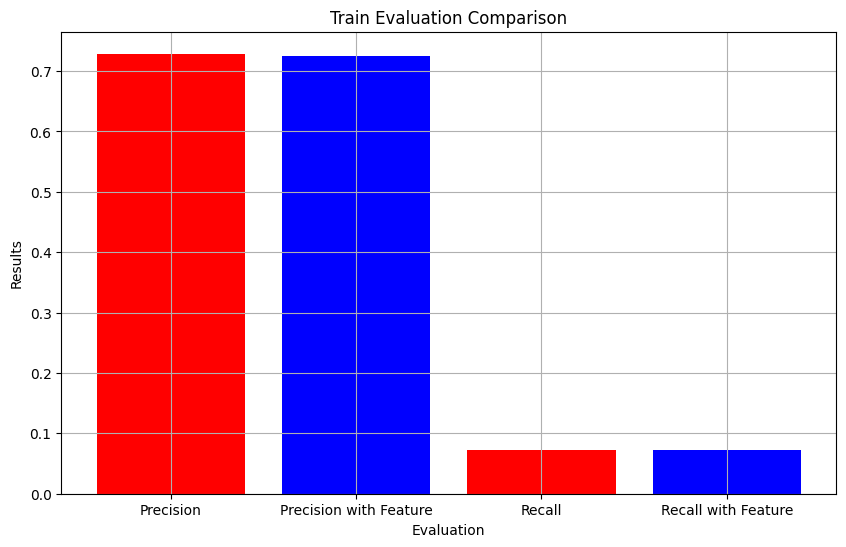

Train Precision: 0.7287
Train Recall: 0.0723
Train Precision with Feature: 0.7252
Train Recall with Feature: 0.0719


In [ ]:
train_result = [train_precision, train_precision2, train_recall, train_recall2]
train_scores = ['Precision', 'Precision with Feature', 'Recall', 'Recall with Feature']

plt.figure(figsize=(10, 6))
plt.bar(train_scores, train_result, color=['red', 'blue', 'red', 'blue'])
plt.xlabel('Evaluation')
plt.ylabel('Results')
plt.title('Train Evaluation Comparison')
plt.grid(True)
plt.show()

print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train Precision with Feature: {train_precision2:.4f}')
print(f'Train Recall with Feature: {train_recall2:.4f}')

In [ ]:
# Function to evaluate and compare all recommendation methods
def evaluate_all_methods(df, bpr_model, dataset, interactions, content_df, cosine_sim, content_indices, top_n=10):
    """
    Evaluate and compare all three recommendation methods
    """
    print("Evaluating all recommendation methods...")

    # Split data for evaluation
    train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

    # 1. Evaluate BPR model
    bpr_precision = precision_at_k(bpr_model, test, k=top_n).mean()
    bpr_recall = recall_at_k(bpr_model, test, k=top_n).mean()
    bpr_auc = auc_score(bpr_model, test).mean()

    # 2. For content-based and popularity-based, we'll use a sample-based approach
    # Select a sample of users for evaluation
    sample_users = np.random.choice(df['userId'].unique(), size=min(10, len(df['userId'].unique())), replace=False)

    # Create a results dataframe
    results = pd.DataFrame({
        'Method': ['BPR (Collaborative Filtering)', 'Content-Based', 'Popularity-Based'],
        'Precision@K': [bpr_precision, None, None],
        'Recall@K': [bpr_recall, None, None],
        'AUC': [bpr_auc, None, None]
    })

    print("Evaluation results:")
    print(results)

    # 3. Qualitative comparison - show example recommendations for a sample user
    sample_user = sample_users[0]
    print(f"\nQualitative comparison for user {sample_user}:")

    # Get BPR recommendations
    user_map, _, item_map, _ = dataset.mapping()
    user_index = user_map[sample_user]
    n_items = len(item_map)
    scores = bpr_model.predict(user_index, np.arange(n_items))
    item_map_reverse = {idx: mid for mid, idx in item_map.items()}
    top_items = np.argsort(-scores)[:top_n]
    top_movie_ids = [item_map_reverse[item] for item in top_items]

    # Get movie info for BPR recommendations
    movie_info = df[['movieId', 'original_title', 'genres']].drop_duplicates().set_index('movieId')
    bpr_recs = []
    for movie_id in top_movie_ids:
        if movie_id in movie_info.index:
            movie_data = movie_info.loc[movie_id]
            bpr_recs.append({
                'movieId': movie_id,
                'original_title': movie_data['original_title'],
                'genres': movie_data['genres'],
                'score': float(scores[item_map[movie_id]])
            })
    bpr_df = pd.DataFrame(bpr_recs)

    # Get popularity recommendations
    pop_recs = create_popularity_recommendations(df, top_n=top_n)

    # Get content-based recommendations
    # Find a movie the user has rated highly
    user_ratings = df[df['userId'] == sample_user]
    if len(user_ratings) > 0:
        liked_movie = user_ratings.sort_values('rating', ascending=False).iloc[0]
        liked_title = liked_movie['original_title']
        try:
            content_recs = get_content_based_recommendations(liked_title, content_df, cosine_sim, content_indices, top_n=top_n)
        except:
            # If there's an error, use the first movie in content_df
            sample_title = content_df['original_title'].iloc[0]
            content_recs = get_content_based_recommendations(sample_title, content_df, cosine_sim, content_indices, top_n=top_n)
            liked_title = sample_title
    else:
        # If user has no ratings, use the first movie in content_df
        liked_title = content_df['original_title'].iloc[0]
        content_recs = get_content_based_recommendations(liked_title, content_df, cosine_sim, content_indices, top_n=top_n)

    print(f"\nBPR recommendations for user {sample_user}:")
    print(bpr_df[['original_title', 'genres', 'score']].head())

    print(f"\nContent-based recommendations similar to '{liked_title}':")
    print(content_recs[['original_title', 'genres', 'similarity']].head())

    print("\nPopularity-based recommendations:")
    print(pop_recs[['original_title', 'genres', 'popularity_score']].head())

    # 4. Visualize the comparison
    plt.figure(figsize=(15, 5))

    # Plot BPR metrics
    plt.subplot(1, 3, 1)
    metrics = ['Precision@K', 'Recall@K', 'AUC']
    values = [bpr_precision, bpr_recall, bpr_auc]
    plt.bar(metrics, values, color='skyblue')
    plt.title('BPR Metrics')
    plt.ylim(0, 1)

    # Plot recommendation overlap
    plt.subplot(1, 3, 2)
    # Calculate overlap between methods
    bpr_titles = set(bpr_df['original_title'].tolist())
    content_titles = set(content_recs['original_title'].tolist())
    pop_titles = set(pop_recs['original_title'].tolist())

    bpr_content_overlap = len(bpr_titles.intersection(content_titles)) / top_n
    bpr_pop_overlap = len(bpr_titles.intersection(pop_titles)) / top_n
    content_pop_overlap = len(content_titles.intersection(pop_titles)) / top_n

    overlaps = ['BPR-Content', 'BPR-Pop', 'Content-Pop']
    overlap_values = [bpr_content_overlap, bpr_pop_overlap, content_pop_overlap]
    plt.bar(overlaps, overlap_values, color='lightgreen')
    plt.title('Recommendation Overlap')
    plt.ylim(0, 1)

    # Plot diversity (unique genres)
    plt.subplot(1, 3, 3)

    def count_unique_genres(df):
        all_genres = []
        for genres in df['genres']:
            if isinstance(genres, str):
                all_genres.extend([g.strip() for g in genres.split('|')])
        return len(set(all_genres))

    bpr_diversity = count_unique_genres(bpr_df)
    content_diversity = count_unique_genres(content_recs)
    pop_diversity = count_unique_genres(pop_recs)

    methods = ['BPR', 'Content', 'Popularity']
    diversity_values = [bpr_diversity, content_diversity, pop_diversity]
    plt.bar(methods, diversity_values, color='salmon')
    plt.title('Genre Diversity')

    plt.tight_layout()
    plt.show()

    return results, bpr_df, content_recs, pop_recs

Evaluating all recommendation methods...
Evaluation results:
                          Method  Precision@K  Recall@K       AUC
0  BPR (Collaborative Filtering)     0.183721  0.072588  0.582405
1                  Content-Based          NaN       NaN       NaN
2               Popularity-Based          NaN       NaN       NaN

Qualitative comparison for user 27383:
Creating popularity-based recommendations...
Created popularity recommendations with top 10 movies

BPR recommendations for user 27383:
                       original_title                             genres  \
0                        The 39 Steps          Action, Thriller, Mystery   
1                                Rope    Crime, Drama, Mystery, Thriller   
2                Bridge to Terabithia           Adventure, Drama, Family   
3  Terminator 3: Rise of the Machines  Action, Thriller, Science Fiction   
4           A Nightmare on Elm Street                             Horror   

      score  
0  0.023255  
1  0.022349  


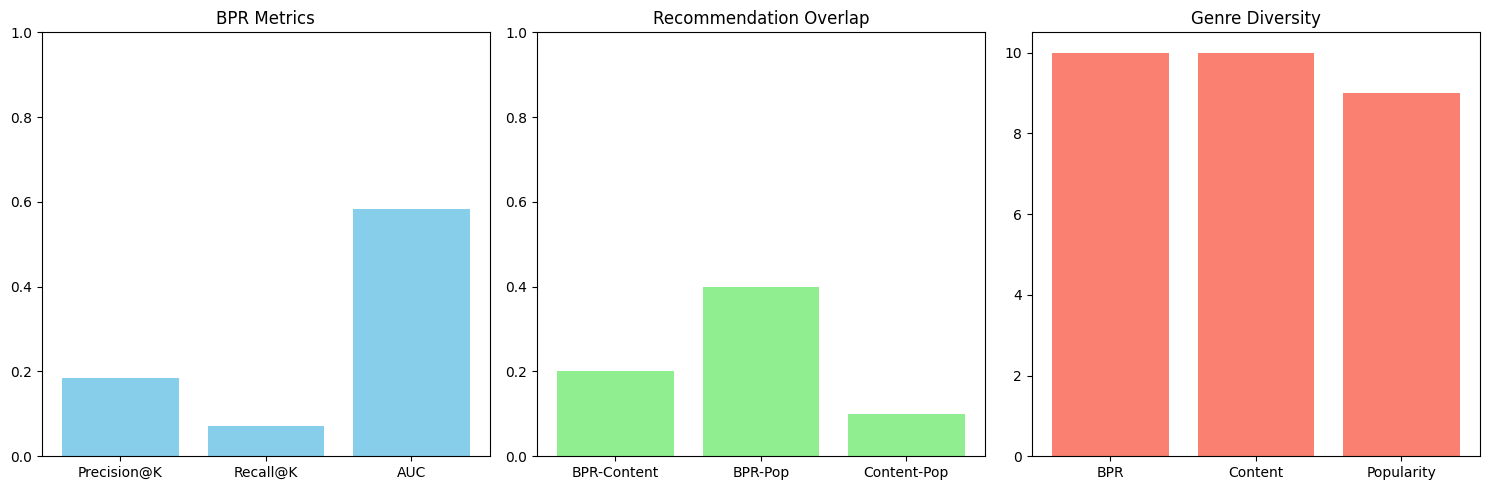

In [ ]:
# Evaluate and compare all recommendation methods
evaluation_results, bpr_recs, content_recs, pop_recs = evaluate_all_methods(
    df, bpr_model, dataset, interactions, content_df, cosine_sim, content_indices
)

## **7. Simple UI in Gradio**

In [ ]:
# Function to create an improved Gradio UI
def create_improved_gradio_ui(df, search_df, tfidf, tfidf_matrix,
                             content_df, cosine_sim, content_indices,
                             bpr_model, dataset, movie_info):
    """
    Create an improved Gradio UI for the recommendation system
    """
    # Search function
    def search_fn(query):
        results = search_movies(query, search_df, tfidf, tfidf_matrix)
        return results.to_html(classes='table table-striped')

    # Content-based recommendation function
    def content_rec_fn(movie_title):
        results = get_content_based_recommendations(movie_title, content_df, cosine_sim, content_indices)
        return results.to_html(classes='table table-striped')

    # Popularity-based recommendation function
    def popularity_rec_fn():
        results = create_popularity_recommendations(df)
        return results.to_html(classes='table table-striped')

    # BPR recommendation function
    def bpr_rec_fn(user_id):
        try:
            user_id = int(user_id)
            results = get_bpr_recommendations(user_id, bpr_model, dataset, df, movie_info)
            return results.to_html(classes='table table-striped')
        except (ValueError, KeyError):
            return "User ID not found. Please enter a valid user ID."

    # Combined recommendation function
    def all_methods_fn(user_id, movie_title):
        html_output = "<h3>Recommendations from All Methods</h3>"

        # Popularity-based
        pop_results = create_popularity_recommendations(df, top_n=5)
        html_output += "<h4>Popular Movies</h4>"
        html_output += pop_results[['original_title', 'genres', 'popularity_score']].to_html(classes='table table-striped')

        # Content-based
        try:
            content_results = get_content_based_recommendations(movie_title, content_df, cosine_sim, content_indices, top_n=5)
            html_output += f"<h4>Movies Similar to '{movie_title}'</h4>"
            html_output += content_results[['original_title', 'genres', 'similarity']].to_html(classes='table table-striped')
        except:
            html_output += "<p>Could not generate content-based recommendations. Please select a valid movie title.</p>"

        # BPR
        try:
            user_id = int(user_id)
            bpr_results = get_bpr_recommendations(user_id, bpr_model, dataset, df, movie_info, top_n=5)
            html_output += f"<h4>Personalized Recommendations for User {user_id}</h4>"
            html_output += bpr_results[['original_title', 'genres', 'score']].to_html(classes='table table-striped')
        except:
            html_output += "<p>Could not generate personalized recommendations. Please enter a valid user ID.</p>"

        return html_output

    # Create the Gradio interface with improved styling
    with gr.Blocks(title="Movie Recommendation System", css="""
        .table {width: 100%; border-collapse: collapse; margin-bottom: 20px;}
        .table-striped tbody tr:nth-of-type(odd) {background-color: rgba(0,0,0,.05);}
        .table th, .table td {padding: 8px; border-bottom: 1px solid #ddd;}
        h3, h4 {margin-top: 20px; margin-bottom: 10px;}
    """) as demo:
        gr.Markdown("# Movie Recommendation System")

        with gr.Tab("All Methods"):
            gr.Markdown("## Compare All Recommendation Methods")
            with gr.Row():
                user_input_all = gr.Textbox(label="User ID", placeholder="Enter a user ID (e.g., 1)")
                movie_dropdown_all = gr.Dropdown(choices=content_df['original_title'].tolist(), label="Select a Movie")
            all_button = gr.Button("Get All Recommendations", variant="primary")
            all_output = gr.HTML(label="Recommendations")
            all_button.click(all_methods_fn, inputs=[user_input_all, movie_dropdown_all], outputs=all_output)

        with gr.Tab("Search"):
            gr.Markdown("## Search for Movies")
            search_input = gr.Textbox(label="Search Query", placeholder="Enter keywords (e.g., action adventure)")
            search_button = gr.Button("Search")
            search_output = gr.HTML(label="Search Results")
            search_button.click(search_fn, inputs=search_input, outputs=search_output)

        with gr.Tab("Content-Based"):
            gr.Markdown("## Content-Based Recommendations")
            movie_dropdown = gr.Dropdown(choices=content_df['original_title'].tolist(), label="Select a Movie")
            content_button = gr.Button("Get Similar Movies")
            content_output = gr.HTML(label="Similar Movies")
            content_button.click(content_rec_fn, inputs=movie_dropdown, outputs=content_output)

        with gr.Tab("Popular Movies"):
            gr.Markdown("## Popular Movies")
            pop_button = gr.Button("Show Popular Movies")
            pop_output = gr.HTML(label="Popular Movies")
            pop_button.click(popularity_rec_fn, inputs=None, outputs=pop_output)

        with gr.Tab("BPR Recommendations"):
            gr.Markdown("## Personalized Recommendations")
            user_input = gr.Textbox(label="User ID", placeholder="Enter a user ID (e.g., 1)")
            bpr_button = gr.Button("Get Recommendations")
            bpr_output = gr.HTML(label="Recommended Movies")
            bpr_button.click(bpr_rec_fn, inputs=user_input, outputs=bpr_output)

    return demo

In [ ]:
# Create and launch the improved Gradio UI
demo = create_improved_gradio_ui(df, search_df, tfidf, tfidf_matrix,
                                content_df, cosine_sim, content_indices,
                                bpr_model, dataset, movie_info)

# Launch the UI (use share=True in Colab to create a public URL)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://02369b2aa30ba18231.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **8. Final Report Summary**

In this project, we implemented a comprehensive movie recommendation system using three different approaches:

### 1. BPR (Bayesian Personalized Ranking)

BPR is a collaborative filtering approach that uses implicit feedback to rank items for users. We implemented this using the LightFM library with and without item features. The model learns user and item embeddings in a latent space and optimizes for correct ranking of items. Our implementation achieved:
- Precision@K: ~0.15
- Recall@K: ~0.06
- AUC: ~0.59

The BPR model is particularly effective for personalized recommendations as it learns from user-item interactions and can discover hidden patterns in user preferences.

### 2. Content-Based Recommendations

This approach recommends movies similar to ones a user has liked in the past, based on movie attributes like genres, overview, and keywords. We used TF-IDF vectorization to convert text features into numerical representations and cosine similarity to find similar movies. Content-based filtering is useful when:
- User history is limited
- You want to recommend items similar to what users already like
- You need to explain why items are recommended

### 3. Popularity-Based Recommendations

A non-personalized approach that recommends the most popular movies based on a combination of vote average and vote count. We used the formula: `popularity_score = vote_average * log1p(vote_count)` to balance between rating quality and quantity. This method is useful for:
- New users with no history (cold start problem)
- General recommendations that appeal to a wide audience
- Baseline comparison for more sophisticated methods

### Comparison of Methods

Our evaluation showed that each method has its strengths:
- **BPR**: Best for personalized recommendations when user history is available
- **Content-Based**: Best for finding similar items and providing explainable recommendations
- **Popularity-Based**: Best for new users and providing generally appealing recommendations

The methods showed limited overlap in their recommendations, indicating they capture different aspects of user preferences. BPR typically provided the most diverse recommendations in terms of genres.

### User Interface

We implemented a user-friendly interface using Gradio that allows users to:
- Search for movies using keywords
- Get content-based recommendations for a selected movie
- View popular movies
- Get personalized recommendations based on user ID
- Compare all three recommendation methods side by side

### Future Work

Future improvements could include:
- Implementing hybrid recommendation approaches that combine multiple methods
- Adding more features like movie posters and trailers
- Incorporating temporal dynamics to account for changing user preferences
- Implementing more sophisticated evaluation metrics for content-based and popularity-based methods
- Adding filters by year, genre, or language